In [1]:
# Transaction Analysis and Anomaly Detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from pathlib import Path
from scipy import stats
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")


In [2]:
# Function to load the processed parquet files
def load_processed_data(n_files=None):
    """
    Load processed parquet files
    
    Parameters:
    n_files (int): Number of files to load, if None, load all files
    
    Returns:
    pandas.DataFrame: Combined dataframe from all loaded files
    """
    processed_path = Path('processed_chunks')
    files = list(processed_path.glob('*.parquet'))
    
    if n_files:
        files = files[:n_files]  # Load only specified number of files for testing
    
    print(f"Loading {len(files)} parquet files...")
    
    # Use list comprehension with tqdm for progress tracking
    dfs = [pd.read_parquet(file) for file in tqdm(files)]
    
    if not dfs:
        raise ValueError("No data files found or loaded")
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Load merchant reference data
def load_merchant_reference():
    """
    Load merchant reference data
    
    Returns:
    pandas.DataFrame: Merchant reference dataframe
    """
    try:
        merchants_ref = pd.read_csv('transaction_data/reference/merchants_reference.csv')
        return merchants_ref
    except Exception as e:
        print(f"Error loading merchant reference data: {e}")
        return None

# Load a sample of data for exploration (to avoid memory issues)
sample_data = load_processed_data(n_files=10)  # Start with 5 files for exploration
print(f"Sample data shape: {sample_data.shape}")

# Display sample data
sample_data.head()


Loading 10 parquet files...


  0%|          | 0/10 [00:00<?, ?it/s]

Sample data shape: (17085000, 21)


,transaction_id,timestamp,user_id,merchant_id,merchant_name,merchant_category,amount,currency,location_country,location_city,is_online,device_type,status,missing_amount,is_amount_outlier,day_of_week,is_weekend,hour,time_period,days_since_transaction,high_value_online
0,7d40ea78-796a-4e07-92b5-543fc2d41375,2025-04-07,USER00056168,MERCH000620,money bank,Financial,40.549999,GBP,Brazil,Fortaleza,True,Mobile,completed,False,False,0,False,0,night,35,False
1,d6eca232-ce52-48a0-b6c7-bf5aa52e9f98,2025-04-07,USER00082086,MERCH000080,finance credit,Financial,10.000000,EUR,Australia,Perth,False,unknown,completed,False,False,0,False,0,night,35,False
2,e597fe74-f98b-4927-be38-7b1db748a5d4,2025-04-07,USER00094393,MERCH000156,city mart,Retail,57.900002,JPY,Mexico,Tijuana,False,unknown,pending,False,False,0,False,0,night,35,False
3,e9df9a90-1e85-4450-9137-17788957e714,2025-04-07,USER00046636,MERCH000515,health center,Healthcare,25.260000,EUR,Australia,Sydney,False,unknown,completed,False,False,0,False,0,night,35,False
4,2e5fe087-2a5d-49ed-99b0-cb8e330d3304,2025-04-07,USER00087000,MERCH000501,utility services,Utilities,106.010002,GBP,Canada,Ottawa,False,unknown,completed,False,False,0,False,0,night,35,False


In [3]:
# Basic data exploration
print("Data types:")
print(sample_data.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(sample_data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(sample_data.describe(include='all'))

# Convert timestamp to datetime if not already
if not pd.api.types.is_datetime64_any_dtype(sample_data['timestamp']):
    sample_data['timestamp'] = pd.to_datetime(sample_data['timestamp'])

# Add derived time columns
sample_data['date'] = sample_data['timestamp'].dt.date
sample_data['hour'] = sample_data['timestamp'].dt.hour
sample_data['day_of_week'] = sample_data['timestamp'].dt.day_name()
sample_data['month'] = sample_data['timestamp'].dt.month
sample_data['day'] = sample_data['timestamp'].dt.day

# Load merchant reference data and merge
merchants_ref = load_merchant_reference()
if merchants_ref is not None:
    print("\nMerchant reference data:")
    print(merchants_ref.head())
    
    # Merge with transaction data if needed
    if 'merchant_category_detailed' in merchants_ref.columns and 'merchant_id' in merchants_ref.columns:
        sample_data = sample_data.merge(
            merchants_ref[['merchant_id', 'merchant_category_detailed']], 
            on='merchant_id', 
            how='left'
        )

Data types:
transaction_id            string[python]
timestamp                 datetime64[ns]
user_id                   string[python]
merchant_id               string[python]
merchant_name             string[python]
merchant_category               category
amount                           float32
currency                        category
location_country                category
location_city                   category
is_online                           bool
device_type                     category
status                          category
missing_amount                      bool
is_amount_outlier                   bool
day_of_week                        int32
is_weekend                          bool
hour                               int32
time_period                       object
days_since_transaction             int64
high_value_online                   bool
dtype: object

Missing values per column:
transaction_id            0
timestamp                 0
user_id                   0
m

Transaction counts by merchant category:
merchant_category
Entertainment    1859398
Travel           1825534
Education        1726307
Food & Dining    1690903
Healthcare       1672792
Financial        1658485
Retail           1657807
Technology       1620869
Utilities        1524465
Services         1506127
unknown           342313
Name: count, dtype: int64


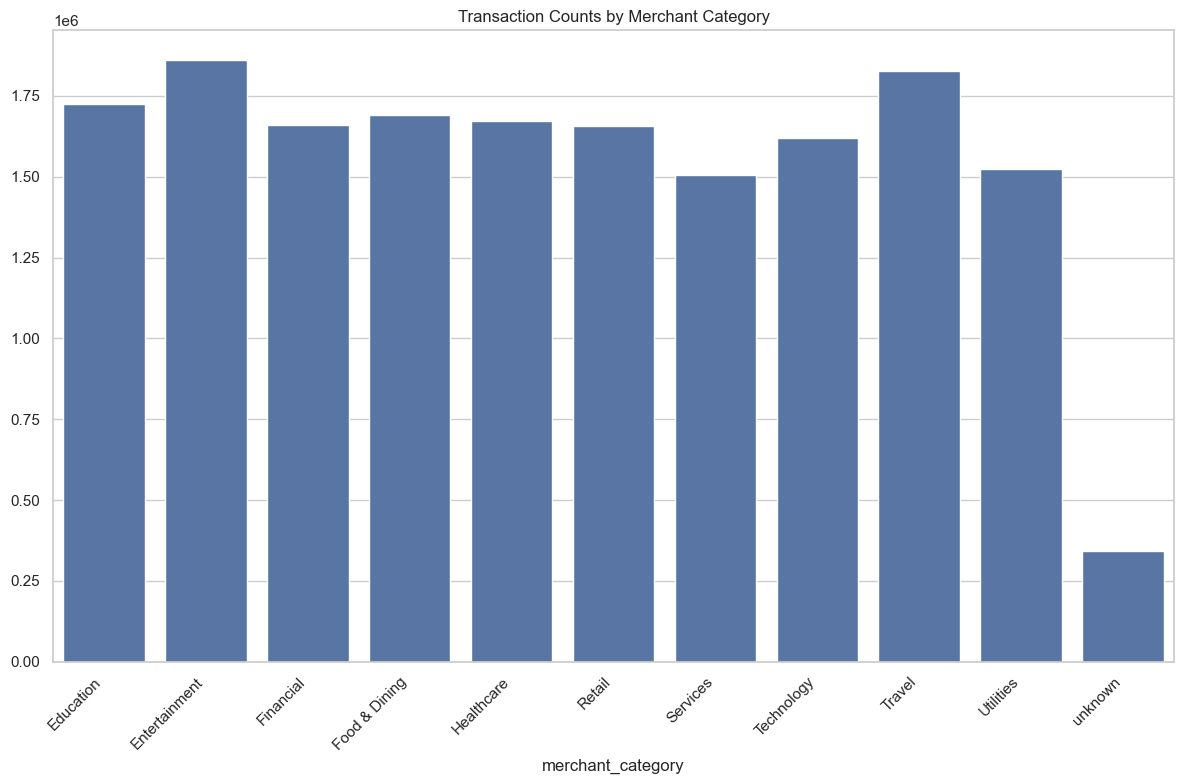

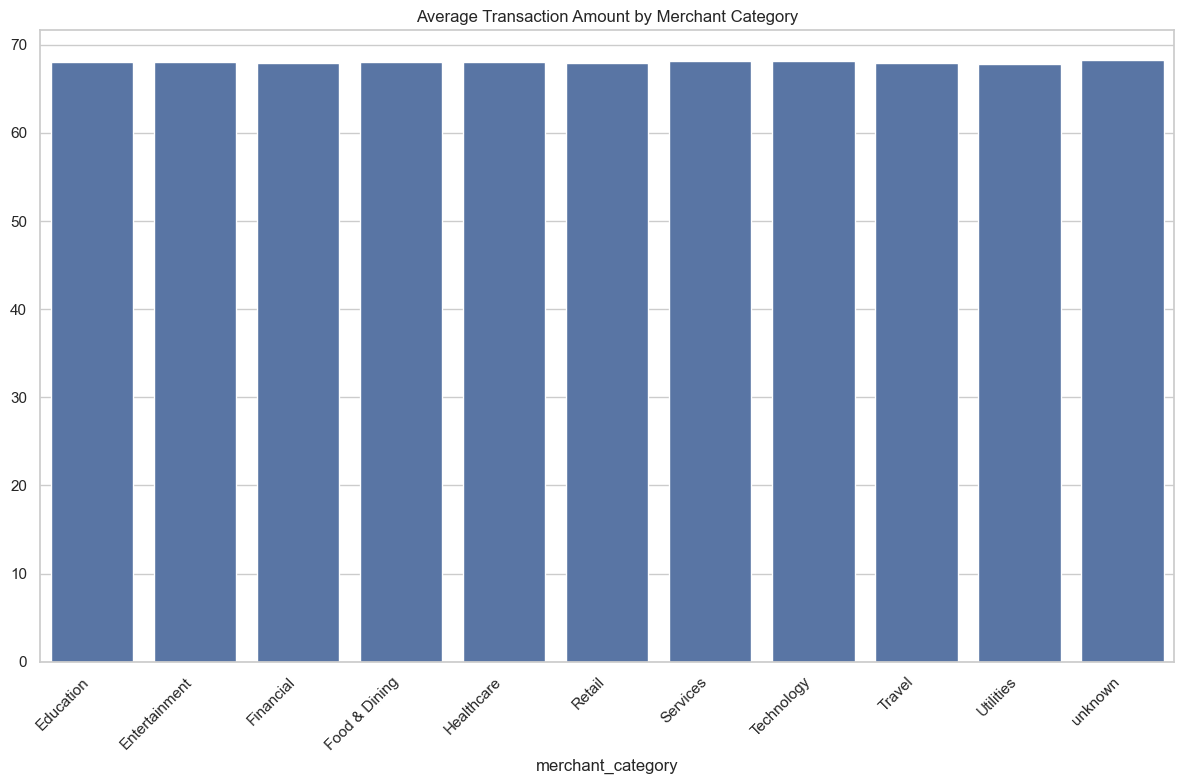

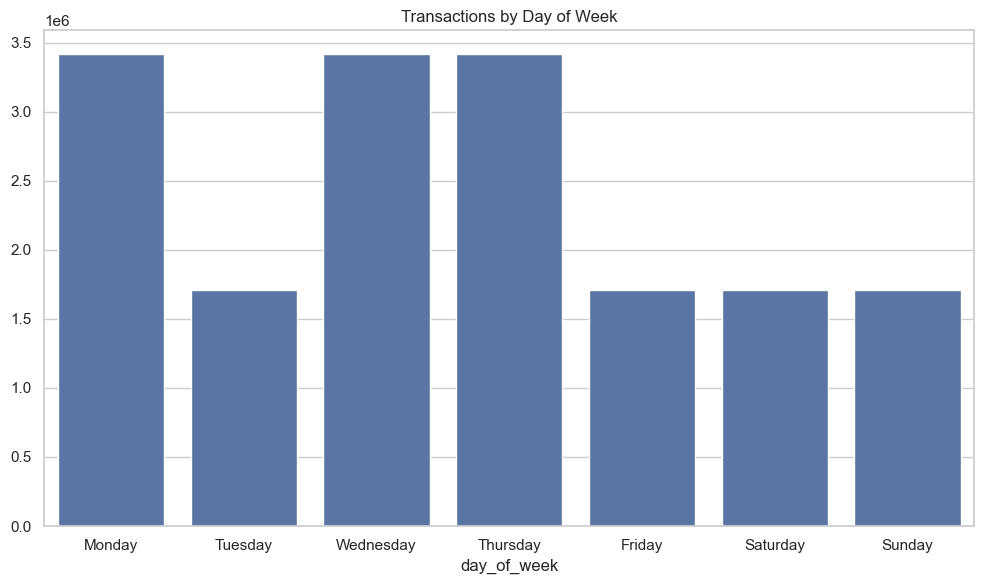

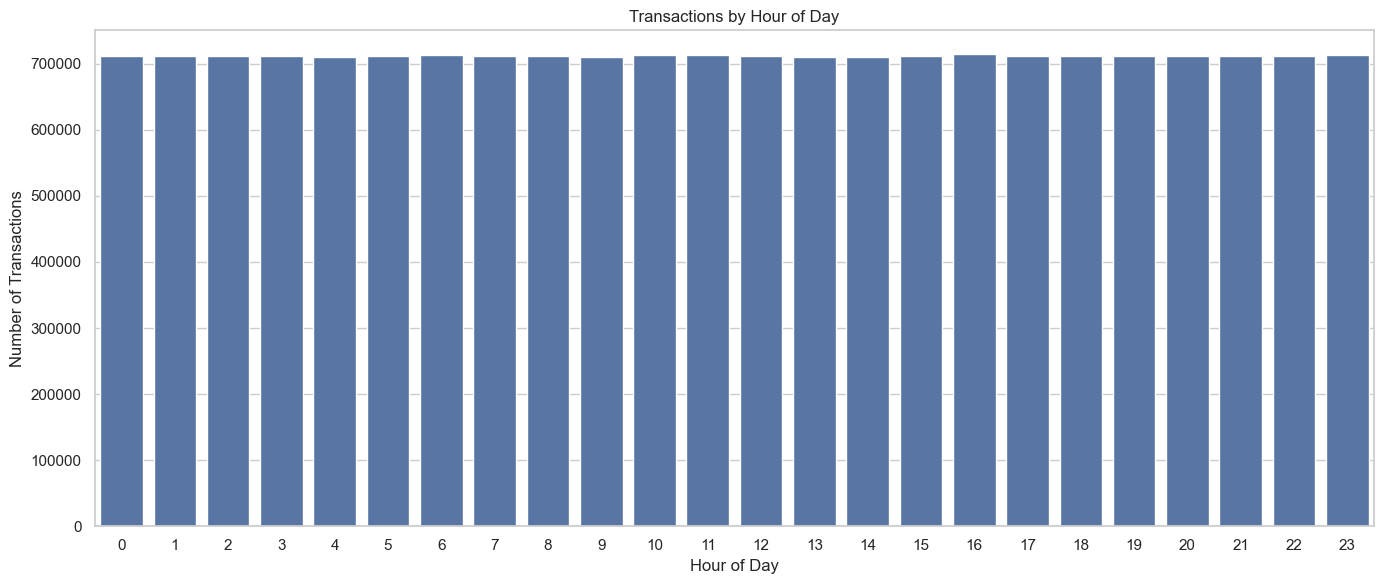

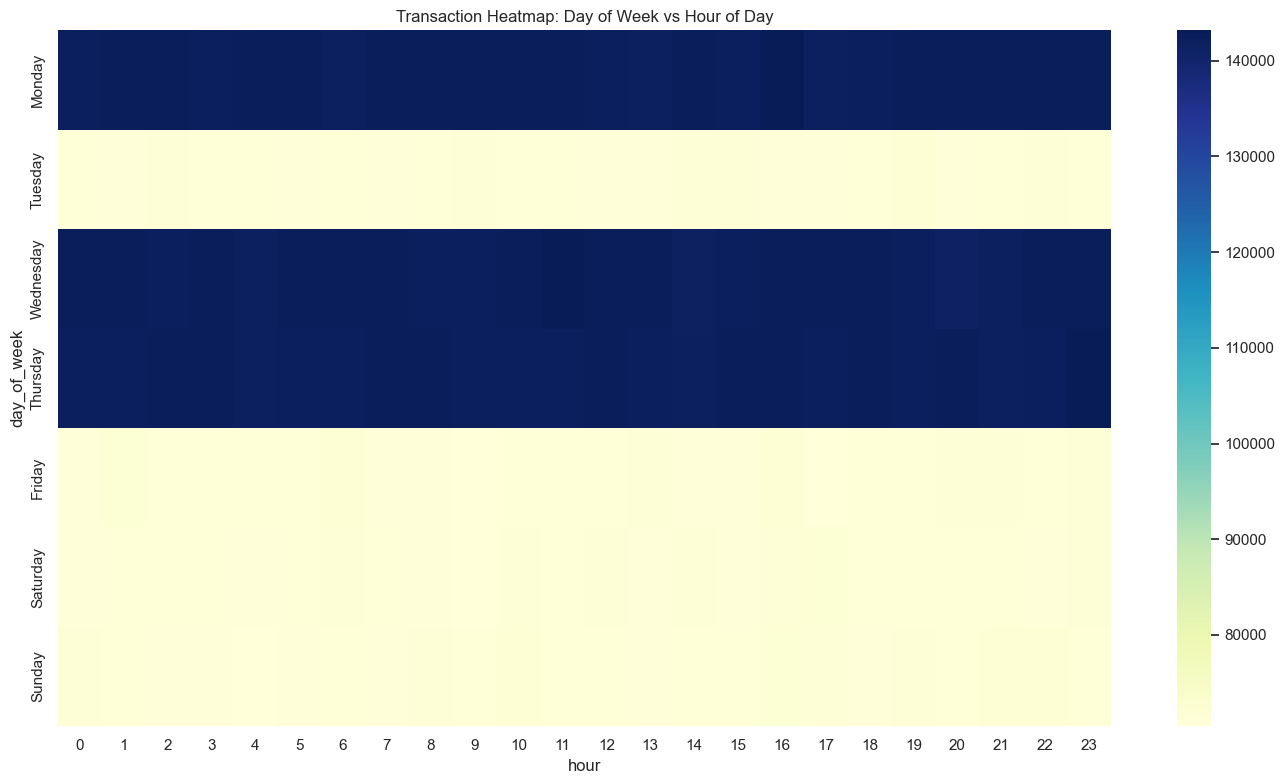

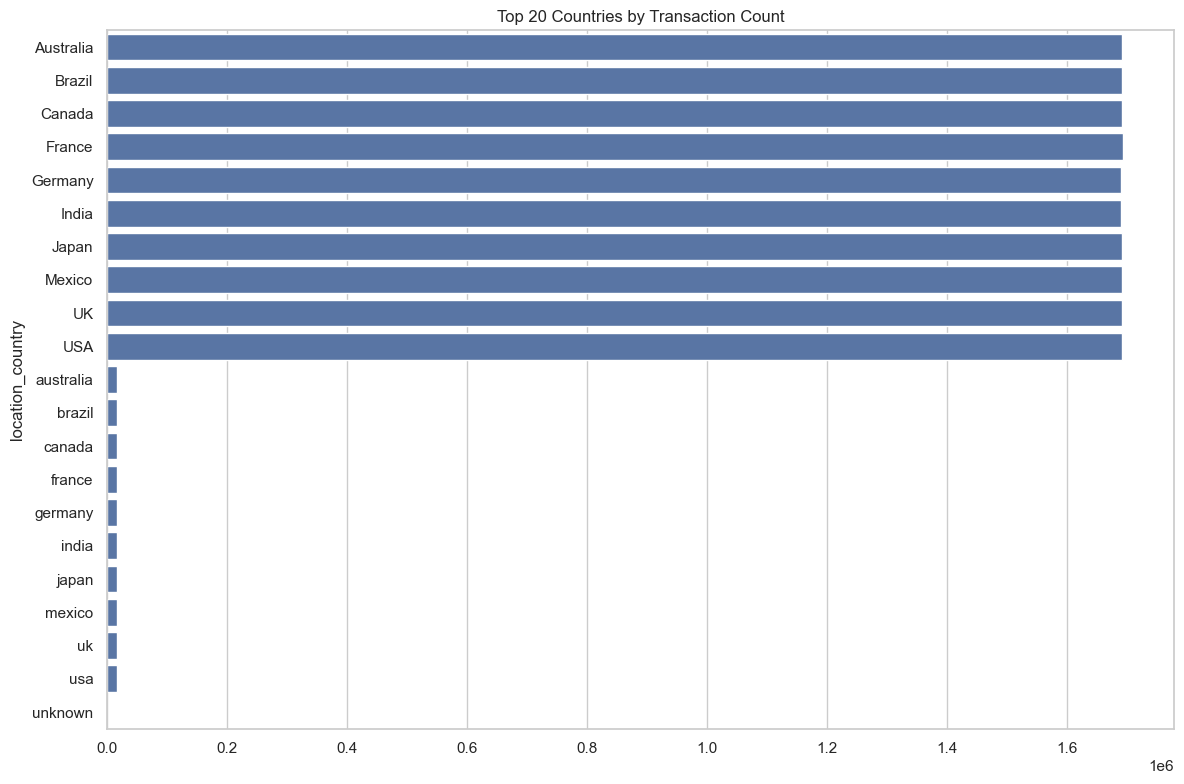

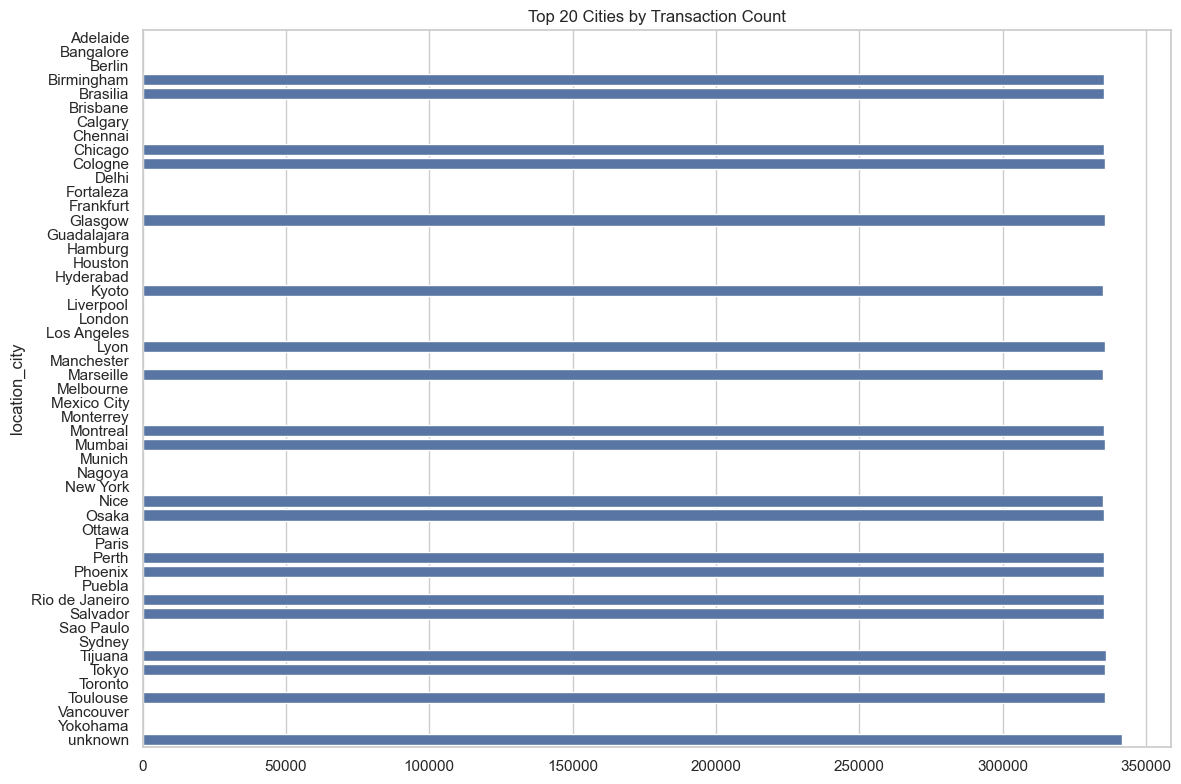

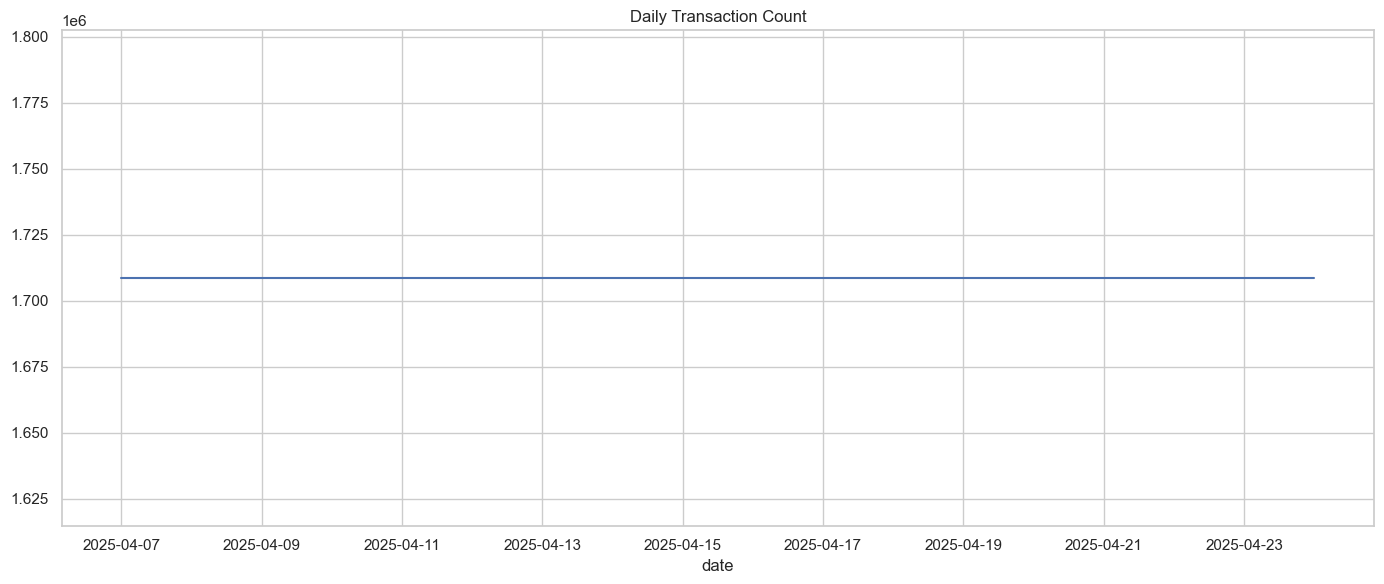

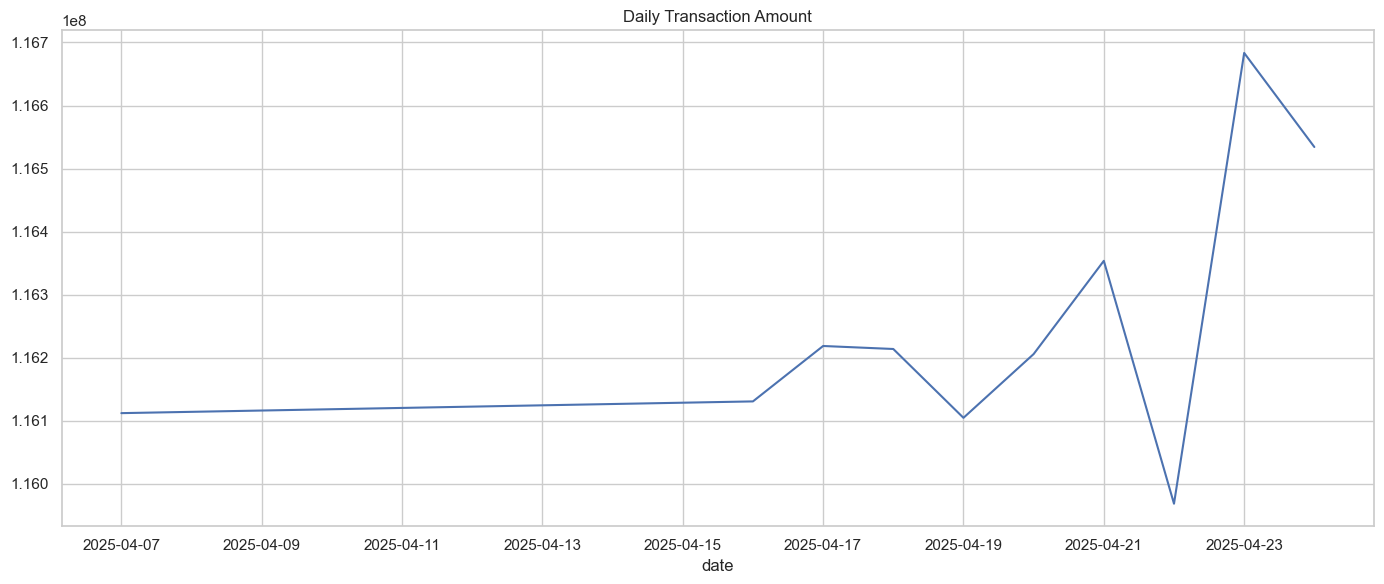

In [4]:
# 3.1 Analysis by Merchant Category
print("Transaction counts by merchant category:")
category_counts = sample_data['merchant_category'].value_counts()
print(category_counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Transaction Counts by Merchant Category')
plt.tight_layout()
plt.show()

# Average transaction amount by merchant category
plt.figure(figsize=(12, 8))
avg_amount_by_category = sample_data.groupby('merchant_category')['amount'].mean().sort_values(ascending=False)
sns.barplot(x=avg_amount_by_category.index, y=avg_amount_by_category.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Transaction Amount by Merchant Category')
plt.tight_layout()
plt.show()

# 3.2 Day of Week and Hour of Day Analysis
# Transactions by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = sample_data['day_of_week'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Transactions by Day of Week')
plt.tight_layout()
plt.show()

# Transactions by hour of day
plt.figure(figsize=(14, 6))
hour_counts = sample_data['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

# Heatmap of day of week vs hour of day
plt.figure(figsize=(14, 8))
heatmap_data = pd.crosstab(sample_data['day_of_week'], sample_data['hour'])
heatmap_data = heatmap_data.reindex(day_order)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt='d')
plt.title('Transaction Heatmap: Day of Week vs Hour of Day')
plt.tight_layout()
plt.show()

# 3.3 Geographic Analysis
# Transaction counts by country
plt.figure(figsize=(12, 8))
country_counts = sample_data['location_country'].value_counts().head(20)
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title('Top 20 Countries by Transaction Count')
plt.tight_layout()
plt.show()

# Top cities by transaction volume
plt.figure(figsize=(12, 8))
city_counts = sample_data['location_city'].value_counts().head(20)
sns.barplot(x=city_counts.values, y=city_counts.index)
plt.title('Top 20 Cities by Transaction Count')
plt.tight_layout()
plt.show()

# 3.4 Trend Analysis
# Group by date to see trends over time
daily_transactions = sample_data.groupby('date').size()
daily_amount = sample_data.groupby('date')['amount'].sum()

plt.figure(figsize=(14, 6))
daily_transactions.plot()
plt.title('Daily Transaction Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
daily_amount.plot()
plt.title('Daily Transaction Amount')
plt.tight_layout()
plt.show()


In [5]:
# Transaction amounts by merchant category (using aggregation instead of full data)
print("Calculating transaction statistics by merchant category...")
category_stats = sample_data.groupby('merchant_category')['amount'].agg([
    'min', 
    'median', 
    'max', 
    lambda x: x.quantile(0.25),  # First quartile (Q1)
    lambda x: x.quantile(0.75)   # Third quartile (Q3)
]).reset_index()
category_stats.columns = ['merchant_category', 'min', 'median', 'max', '25%', '75%']

# Create manual boxplot with statistics (more memory efficient than px.box with full dataset)
fig = go.Figure()
for _, row in category_stats.iterrows():
    fig.add_trace(go.Box(
        name=row['merchant_category'],
        lowerfence=[row['min']],
        q1=[row['25%']],
        median=[row['median']],
        q3=[row['75%']],
        upperfence=[row['max']],
        boxpoints=False  # Don't show individual points to save memory
    ))
fig.update_xaxes(tickangle=45)
fig.update_layout(height=600, width=900, title='Transaction Amount Distribution by Merchant Category')
fig.show()

# Daily transaction counts (already aggregated, so this is efficient)
print("Analyzing daily transaction patterns...")
daily_counts = sample_data.groupby('date').size().reset_index(name='count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Only plot up to 180 days to keep visualization responsive
if len(daily_counts) > 180:
    print(f"Limiting chart to most recent 180 days out of {len(daily_counts)} total days")
    daily_counts = daily_counts.sort_values('date').tail(180)

fig = px.line(daily_counts, x='date', y='count', 
              title='Daily Transaction Counts Over Time')
fig.update_layout(height=500, width=900)
fig.show()

# Transaction flow by hour and day of week (already aggregated, so this is efficient)
print("Creating hour/day transaction heatmap...")
hourly_day_counts = sample_data.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = px.density_heatmap(hourly_day_counts, x='hour', y='day_of_week', z='count',
                         category_orders={"day_of_week": day_order},
                         title='Transaction Density by Hour and Day of Week')
fig.update_layout(height=500, width=900)
fig.show()

# 5.2 Memory-Efficient Geographic visualization
print("Aggregating geographic data...")
# Aggregate data by country (already efficient)
country_data = sample_data.groupby('location_country').agg({
    'transaction_id': 'count',
    'amount': ['sum', 'mean']  # Add mean to get average transaction amount
}).reset_index()

# Rename columns for clarity
country_data.columns = ['country', 'transaction_count', 'total_amount', 'avg_transaction_amount']

# Limit to top 50 countries if there are many
if len(country_data) > 50:
    print(f"Limiting choropleth map to top 50 countries by transaction count out of {len(country_data)} total")
    country_data = country_data.sort_values('transaction_count', ascending=False).head(50)

# Create choropleth map
fig = px.choropleth(country_data, 
                    locations='country', 
                    locationmode='country names',
                    color='transaction_count', 
                    hover_name='country',
                    hover_data=['transaction_count', 'total_amount'],
                    title='Transaction Count by Country',
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(height=600, width=900)
fig.show()

# 5.3 Memory-Efficient Transaction patterns over time by category
print("Analyzing trends by merchant category...")
# Group by date and merchant category (already efficient)
category_time_data = sample_data.groupby(['date', 'merchant_category']).size().reset_index(name='count')
category_time_data['date'] = pd.to_datetime(category_time_data['date'])

# Limit to top 5 merchant categories by volume to avoid cluttered visualization
top_categories = sample_data['merchant_category'].value_counts().head(5).index.tolist()
category_time_data_filtered = category_time_data[category_time_data['merchant_category'].isin(top_categories)]

print(f"Showing transaction trends for top {len(top_categories)} merchant categories")
fig = px.line(category_time_data_filtered, x='date', y='count', color='merchant_category',
              title=f'Transaction Counts for Top {len(top_categories)} Merchant Categories Over Time')
fig.update_layout(height=500, width=900)
fig.show()

# 5.4 Memory-Efficient Customer segmentation
print("Performing customer segmentation analysis...")
# Sample users if there are too many to process efficiently
max_users = 50000
user_sample = None
user_count = sample_data['user_id'].nunique()

if user_count > max_users:
    print(f"Sampling {max_users} users out of {user_count} for segmentation analysis")
    user_sample = sample_data['user_id'].drop_duplicates().sample(max_users).tolist()
    user_data = sample_data[sample_data['user_id'].isin(user_sample)]
else:
    user_data = sample_data

# Calculate metrics per user efficiently with a single groupby operation
user_metrics = user_data.groupby('user_id').agg({
    'transaction_id': 'count',
    'amount': ['sum', 'mean'],
    'timestamp': ['min', 'max']
}).reset_index()

user_metrics.columns = ['user_id', 'transaction_count', 'total_spend', 'avg_transaction', 'first_transaction', 'last_transaction']

# Calculate recency
latest_date = user_data['timestamp'].max()
user_metrics['recency_days'] = (latest_date - user_metrics['last_transaction']).dt.days
user_metrics['tenure_days'] = (user_metrics['last_transaction'] - user_metrics['first_transaction']).dt.days + 1  # Add 1 to avoid 0 days

# Handle potential issues with qcut (which can fail with too many ties)
try:
    user_metrics['spend_segment'] = pd.qcut(user_metrics['total_spend'], 3, labels=['Low', 'Medium', 'High'])
except ValueError:
    print("Using cut instead of qcut for spend segmentation due to too many ties")
    user_metrics['spend_segment'] = pd.cut(user_metrics['total_spend'], 3, labels=['Low', 'Medium', 'High'])

try:
    user_metrics['frequency_segment'] = pd.qcut(user_metrics['transaction_count'], 3, labels=['Low', 'Medium', 'High'])
except ValueError:
    print("Using cut instead of qcut for frequency segmentation due to too many ties")
    user_metrics['frequency_segment'] = pd.cut(user_metrics['transaction_count'], 3, labels=['Low', 'Medium', 'High'])

try:
    user_metrics['recency_segment'] = pd.qcut(user_metrics['recency_days'], 3, labels=['Recent', 'Moderate', 'Old'])
except ValueError:
    print("Using cut instead of qcut for recency segmentation due to too many ties")
    user_metrics['recency_segment'] = pd.cut(user_metrics['recency_days'], 3, labels=['Recent', 'Moderate', 'Old'])

# Sample for visualization if still too large
if len(user_metrics) > 5000:
    print(f"Sampling {5000} users for visualization out of {len(user_metrics)}")
    viz_sample = user_metrics.sample(5000)
else:
    viz_sample = user_metrics

# Visualize user segments with a subset
fig = px.scatter(viz_sample, x='transaction_count', y='total_spend', 
                color='recency_segment', size='avg_transaction',
                hover_data=['user_id', 'tenure_days'],
                title='Customer Segmentation by Spend, Frequency and Recency (Sample)')
fig.update_layout(height=600, width=900)
fig.show()

# Extra: Add summary statistics by segment for complete insights without visualization limits
print("\nSegment Summary Statistics:")
segment_stats = user_metrics.groupby(['spend_segment', 'frequency_segment', 'recency_segment']).agg({
    'user_id': 'count',
    'total_spend': 'mean',
    'transaction_count': 'mean',
    'avg_transaction': 'mean',
    'recency_days': 'mean',
    'tenure_days': 'mean'
}).reset_index()

segment_stats.columns = ['Spend', 'Frequency', 'Recency', 'User Count', 'Avg Total Spend', 
                         'Avg Transaction Count', 'Avg Transaction Size', 'Avg Recency Days', 'Avg Tenure Days']
display(segment_stats.sort_values(['Spend', 'Frequency', 'Recency']))

Calculating transaction statistics by merchant category...


Analyzing daily transaction patterns...


Creating hour/day transaction heatmap...


Aggregating geographic data...


Analyzing trends by merchant category...
Showing transaction trends for top 5 merchant categories


Performing customer segmentation analysis...
Sampling 50000 users out of 100000 for segmentation analysis
Using cut instead of qcut for recency segmentation due to too many ties
Sampling 5000 users for visualization out of 50000



Segment Summary Statistics:


,Spend,Frequency,Recency,User Count,Avg Total Spend,Avg Transaction Count,Avg Transaction Size,Avg Recency Days,Avg Tenure Days
0,Low,Low,Recent,0,NaN,NaN,NaN,NaN,NaN
1,Low,Low,Moderate,9699,9568.173828,155.539746,61.587334,0.0,18.0
2,Low,Low,Old,0,NaN,NaN,NaN,NaN,NaN
3,Low,Medium,Recent,0,NaN,NaN,NaN,NaN,NaN
4,Low,Medium,Moderate,4910,9921.750977,170.410591,58.234993,0.0,18.0
5,Low,Medium,Old,0,NaN,NaN,NaN,NaN,NaN
6,Low,High,Recent,0,NaN,NaN,NaN,NaN,NaN
7,Low,High,Moderate,2059,10107.311523,182.243808,55.491352,0.0,18.0
8,Low,High,Old,0,NaN,NaN,NaN,NaN,NaN
9,Medium,Low,Recent,0,NaN,NaN,NaN,NaN,NaN


In [6]:
# ===== MODULAR TRANSACTION ANALYSIS FUNCTIONS =====

import os
import gc
import calendar
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Function 1: Geographic Analysis
def geographic_analysis(df, output_dir="output_visualizations"):
    """Analyze and visualize transaction data by geography"""
    print("\n=== GEOGRAPHIC ANALYSIS ===")
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # For large DataFrames, sample if needed
    if len(df) > 1_000_000:
        print("Dataset too large, sampling 1M rows for geographic analysis...")
        geo_df = df.sample(n=1_000_000)
    else:
        geo_df = df.copy()
    
    # Check for required geographical columns
    required_columns = ['location_country', 'location_city']
    missing_columns = [col for col in required_columns if col not in geo_df.columns]
    
    if missing_columns:
        print(f"Missing required geographic columns: {missing_columns}")
        return None
    
    print("Analyzing transaction data by geography...")
    
    # ----- 1.1 Country-level Analysis -----
    country_counts = geo_df.groupby('location_country').size().reset_index(name='transaction_count')
    country_counts = country_counts.sort_values('transaction_count', ascending=False)
    
    country_values = geo_df.groupby('location_country')['amount'].sum().reset_index(name='transaction_value')
    country_values = country_values.sort_values('transaction_value', ascending=False)
    
    country_metrics = pd.merge(country_counts, country_values, on='location_country', how='outer')
    country_metrics['avg_transaction_value'] = country_metrics['transaction_value'] / country_metrics['transaction_count']
    country_metrics = country_metrics.sort_values('transaction_count', ascending=False).head(20)
    
    # Create choropleth map for transaction counts by country
    print("Creating choropleth map for transaction counts by country...")
    fig = px.choropleth(
        country_metrics, 
        locations='location_country', 
        locationmode='country names',
        color='transaction_count',
        hover_name='location_country',
        hover_data=['transaction_count', 'transaction_value', 'avg_transaction_value'],
        title='Transaction Count by Country',
        color_continuous_scale=px.colors.sequential.Plasma
    )
    
    fig.update_layout(
        height=600, width=1000, title_x=0.5,
        geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth')
    )
    
    fig.write_html(os.path.join(output_dir, "country_transaction_map.html"))
    fig.show()  # Also display in notebook
    
    # ----- 1.2 City-level Analysis -----
    city_counts = geo_df.groupby(['location_country', 'location_city']).size().reset_index(name='transaction_count')
    city_values = geo_df.groupby(['location_country', 'location_city'])['amount'].sum().reset_index(name='transaction_value')
    
    city_metrics = pd.merge(city_counts, city_values, on=['location_country', 'location_city'], how='outer')
    city_metrics['avg_transaction_value'] = city_metrics['transaction_value'] / city_metrics['transaction_count']
    city_metrics = city_metrics.sort_values('transaction_count', ascending=False).head(50)
    
    # Create bar chart for top cities
    print("Creating bar chart for top cities by transaction count...")
    fig = px.bar(
        city_metrics.head(20),
        x='transaction_count',
        y='location_city',
        color='transaction_value',
        color_continuous_scale=px.colors.sequential.Plasma,
        orientation='h',
        title='Top 20 Cities by Transaction Count',
        hover_data=['location_country', 'avg_transaction_value']
    )
    
    fig.update_layout(
        height=700, width=1000, title_x=0.5,
        yaxis={'categoryorder': 'total ascending'},
        xaxis_title='Number of Transactions', yaxis_title='City'
    )
    
    fig.write_html(os.path.join(output_dir, "top_cities_transactions.html"))
    fig.show()  # Also display in notebook
    
    # ----- 1.3 Cross-Border Transaction Analysis -----
    if 'user_id' in geo_df.columns:
        print("Analyzing cross-border transactions...")
        # Determine each user's home country (most frequent transaction country)
        user_home_country = geo_df.groupby('user_id')['location_country'].agg(
            lambda x: x.value_counts().index[0] if len(x) > 0 else 'unknown'
        ).reset_index(name='user_country')
        
        # Merge back to dataset
        geo_df = pd.merge(geo_df, user_home_country, on='user_id', how='left')
        
        # Flag cross-border transactions
        geo_df['is_cross_border'] = geo_df['location_country'] != geo_df['user_country']
        
        # Cross-border transaction metrics
        cross_border_metrics = geo_df.groupby('is_cross_border').agg(
            transaction_count=('transaction_id', 'count'),
            transaction_value=('amount', 'sum'),
            avg_transaction_value=('amount', 'mean')
        ).reset_index()
        
        # Create pie chart for cross-border vs. domestic transactions
        print("Creating pie chart for cross-border vs. domestic transactions...")
        cross_border_metrics['transaction_type'] = cross_border_metrics['is_cross_border'].map(
            {True: 'Cross-Border', False: 'Domestic'}
        )
        
        fig = make_subplots(
            rows=1, cols=2, 
            specs=[[{'type': 'domain'}, {'type': 'domain'}]],
            subplot_titles=('Transaction Count', 'Transaction Value')
        )
        
        fig.add_trace(go.Pie(
            labels=cross_border_metrics['transaction_type'], 
            values=cross_border_metrics['transaction_count'],
            name="Transaction Count"
        ), 1, 1)
        
        fig.add_trace(go.Pie(
            labels=cross_border_metrics['transaction_type'], 
            values=cross_border_metrics['transaction_value'],
            name="Transaction Value"
        ), 1, 2)
        
        fig.update_layout(
            title_text="Cross-Border vs. Domestic Transactions",
            height=500, width=1000, title_x=0.5
        )
        
        fig.write_html(os.path.join(output_dir, "cross_border_distribution.html"))
        fig.show()  # Also display in notebook
    
    # Clean up to free memory
    del geo_df
    gc.collect()
    
    print("Geographic analysis complete.")
    return country_metrics


In [7]:
# Run geographic analysis
print("\nExecuting comprehensive transaction data analysis...")

# Create output directory if it doesn't exist
output_dir = "output_visualizations"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run geographic analysis
print("\n1. Running geographic analysis...")
geo_results = geographic_analysis(sample_data, output_dir)
print("Geographic analysis complete!")

# Add results to the all_results dictionary for later reporting
if 'all_results' not in globals():
    all_results = {}

# Save analysis results
if geo_results is not None:
    all_results['country_metrics'] = geo_results

print("\nAnalysis complete. Results and visualizations saved to", output_dir)


Executing comprehensive transaction data analysis...

1. Running geographic analysis...

=== GEOGRAPHIC ANALYSIS ===
Dataset too large, sampling 1M rows for geographic analysis...
Analyzing transaction data by geography...
Creating choropleth map for transaction counts by country...


Creating bar chart for top cities by transaction count...


Analyzing cross-border transactions...
Creating pie chart for cross-border vs. domestic transactions...


Geographic analysis complete.
Geographic analysis complete!

Analysis complete. Results and visualizations saved to output_visualizations


In [8]:
import calendar
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import gc

In [9]:
# ===== ADVANCED TIME SERIES ANALYSIS =====

def seasonal_trend_analysis(df, output_dir="output_visualizations"):
    """Analyze seasonal patterns and trends in transaction data"""
    print("\n=== SEASONAL AND TREND ANALYSIS ===")
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Check if we're working with a Dask DataFrame
    is_dask = hasattr(df, 'dask')
    
    # For analysis, we need daily aggregated data
    print("Aggregating data for time series analysis...")
    
    if is_dask:
        # For Dask DataFrame
        # This will trigger computation
        daily_df = df.groupby('date').agg({
            'transaction_id': 'count',
            'amount': ['sum', 'mean']
        }).compute()
        
        # Flatten the column hierarchy
        daily_df.columns = ['transaction_count', 'transaction_value', 'avg_transaction_value']
        daily_df = daily_df.reset_index()
    else:
        # For pandas DataFrame
        daily_df = df.groupby('date').agg(
            transaction_count=('transaction_id', 'count'),
            transaction_value=('amount', 'sum'),
            avg_transaction_value=('amount', 'mean')
        ).reset_index()
    
    # Ensure date is datetime
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    
    # Sort by date
    daily_df = daily_df.sort_values('date')
    
    # Fill any missing dates
    date_range = pd.date_range(start=daily_df['date'].min(), end=daily_df['date'].max(), freq='D')
    full_date_df = pd.DataFrame({'date': date_range})
    daily_df = pd.merge(full_date_df, daily_df, on='date', how='left')
    daily_df = daily_df.fillna(0)
    
    # Add calendar features
    daily_df['year'] = daily_df['date'].dt.year
    daily_df['month'] = daily_df['date'].dt.month
    daily_df['day'] = daily_df['date'].dt.day
    daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
    daily_df['day_name'] = daily_df['date'].dt.day_name()
    daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6])
    daily_df['month_name'] = daily_df['date'].dt.month_name()
    daily_df['quarter'] = daily_df['date'].dt.quarter
    
    # ----- 2.1 Day of Week Patterns -----
    
    print("Analyzing day of week patterns...")
    dow_patterns = daily_df.groupby('day_name').agg(
        transaction_count=('transaction_count', 'mean'),
        transaction_value=('transaction_value', 'mean'),
        avg_transaction_value=('avg_transaction_value', 'mean')
    ).reset_index()
    
    # Convert day names to categorical for proper ordering
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_patterns['day_name'] = pd.Categorical(dow_patterns['day_name'], categories=day_order, ordered=True)
    dow_patterns = dow_patterns.sort_values('day_name')
    
    # Create visualization for day of week patterns
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Bar(
            x=dow_patterns['day_name'],
            y=dow_patterns['transaction_count'],
            name='Avg Transaction Count',
            marker_color='royalblue'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=dow_patterns['day_name'],
            y=dow_patterns['avg_transaction_value'],
            name='Avg Transaction Value',
            line=dict(color='firebrick', width=3),
            mode='lines+markers'
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title='Transaction Patterns by Day of Week',
        xaxis_title='Day of Week',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        template='plotly_white',
        height=500,
        width=900,
        title_x=0.5
    )
    
    fig.update_yaxes(title_text="Avg Transaction Count", secondary_y=False)
    fig.update_yaxes(title_text="Avg Transaction Value", secondary_y=True)
    
    fig.write_html(os.path.join(output_dir, "day_of_week_patterns.html"))
    fig.show()  # Also display in notebook
    
    # ----- 2.2 Monthly Seasonal Patterns -----
    
    print("Analyzing monthly seasonal patterns...")
    monthly_patterns = daily_df.groupby(['year', 'month', 'month_name']).agg(
        transaction_count=('transaction_count', 'sum'),
        transaction_value=('transaction_value', 'sum'),
        avg_transaction_value=('avg_transaction_value', 'mean'),
        days=('transaction_count', 'count')
    ).reset_index()
    
    # Normalize for months with partial data
    monthly_patterns['daily_avg_count'] = monthly_patterns['transaction_count'] / monthly_patterns['days']
    monthly_patterns['daily_avg_value'] = monthly_patterns['transaction_value'] / monthly_patterns['days']
    
    # Create month-year field for plotting
    monthly_patterns['month_year'] = monthly_patterns['month_name'] + ' ' + monthly_patterns['year'].astype(str)
    
    # Compute month averages across years (seasonal pattern)
    month_avg_patterns = daily_df.groupby('month').agg(
        transaction_count=('transaction_count', 'mean'),
        transaction_value=('transaction_value', 'mean'),
        avg_transaction_value=('avg_transaction_value', 'mean')
    ).reset_index()
    
    # Add month names
    month_avg_patterns['month_name'] = month_avg_patterns['month'].apply(lambda x: calendar.month_name[x])
    
    # Convert to categorical for proper ordering
    month_order = [calendar.month_name[i] for i in range(1, 13)]
    month_avg_patterns['month_name'] = pd.Categorical(
        month_avg_patterns['month_name'], 
        categories=month_order, 
        ordered=True
    )
    month_avg_patterns = month_avg_patterns.sort_values('month_name')
    
    # Create visualization for monthly seasonal patterns
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Bar(
            x=month_avg_patterns['month_name'],
            y=month_avg_patterns['transaction_count'],
            name='Avg Transaction Count',
            marker_color='mediumpurple'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=month_avg_patterns['month_name'],
            y=month_avg_patterns['avg_transaction_value'],
            name='Avg Transaction Value',
            line=dict(color='orangered', width=3),
            mode='lines+markers'
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title='Monthly Seasonal Transaction Patterns',
        xaxis_title='Month',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        template='plotly_white',
        height=500,
        width=1000,
        title_x=0.5
    )
    
    fig.update_yaxes(title_text="Avg Daily Transaction Count", secondary_y=False)
    fig.update_yaxes(title_text="Avg Transaction Value", secondary_y=True)
    
    fig.write_html(os.path.join(output_dir, "monthly_seasonal_patterns.html"))
    fig.show()  # Also display in notebook
    
    # ----- 2.3 Trend Analysis -----
    
    print("Analyzing long-term trends...")
    
    # Resample to weekly data for trend analysis (to reduce noise)
    weekly_df = daily_df.set_index('date')
    weekly_df = weekly_df.resample('W').agg({
        'transaction_count': 'sum',
        'transaction_value': 'sum',
        'avg_transaction_value': 'mean'
    }).reset_index()
    
    # Apply smoothing for trend visualization
    window_size = min(12, len(weekly_df) // 4)  # Use a reasonable window size based on data length
    weekly_df['trend_count'] = weekly_df['transaction_count'].rolling(window=window_size, center=True).mean()
    weekly_df['trend_value'] = weekly_df['transaction_value'].rolling(window=window_size, center=True).mean()
    
    # Create visualization for trend analysis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Raw weekly data
    fig.add_trace(
        go.Scatter(
            x=weekly_df['date'],
            y=weekly_df['transaction_count'],
            name='Weekly Transaction Count',
            line=dict(color='lightsteelblue', width=1),
            opacity=0.5
        ),
        secondary_y=False
    )
    
    # Trend line
    fig.add_trace(
        go.Scatter(
            x=weekly_df['date'],
            y=weekly_df['trend_count'],
            name='Transaction Count Trend',
            line=dict(color='darkblue', width=3)
        ),
        secondary_y=False
    )
    
    # Transaction value trend
    fig.add_trace(
        go.Scatter(
            x=weekly_df['date'],
            y=weekly_df['trend_value'],
            name='Transaction Value Trend',
            line=dict(color='crimson', width=3)
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title='Long-term Transaction Trends',
        xaxis_title='Date',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        template='plotly_white',
        height=600,
        width=1000,
        title_x=0.5,
        hovermode="x unified"
    )
    
    fig.update_yaxes(title_text="Transaction Count", secondary_y=False)
    fig.update_yaxes(title_text="Transaction Value", secondary_y=True)
    
    fig.write_html(os.path.join(output_dir, "transaction_trends.html"))
    fig.show()  # Also display in notebook
    
    # ----- 2.4 Decomposition Analysis -----
    
    # Only perform decomposition if we have enough data points (at least 2 periods)
    if len(weekly_df) >= 104:  # At least 2 years of weekly data
        print("Performing time series decomposition...")
        
        try:
            # Decompose the time series to separate trend, seasonal, and residual components
            result = seasonal_decompose(
                weekly_df['transaction_count'], 
                model='additive', 
                period=52  # 52 weeks in a year
            )
            
            # Create visualization for decomposition
            fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                              subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))
            
            fig.add_trace(
                go.Scatter(x=weekly_df['date'], y=result.observed, mode='lines', name='Observed'),
                row=1, col=1
            )
            
            fig.add_trace(
                go.Scatter(x=weekly_df['date'], y=result.trend, mode='lines', name='Trend'),
                row=2, col=1
            )
            
            fig.add_trace(
                go.Scatter(x=weekly_df['date'], y=result.seasonal, mode='lines', name='Seasonal'),
                row=3, col=1
            )
            
            fig.add_trace(
                go.Scatter(x=weekly_df['date'], y=result.resid, mode='lines', name='Residual'),
                row=4, col=1
            )
            
            fig.update_layout(
                height=800,
                width=1000,
                title_text='Time Series Decomposition',
                title_x=0.5,
                showlegend=False
            )
            
            fig.write_html(os.path.join(output_dir, "time_series_decomposition.html"))
            fig.show()  # Also display in notebook
        
        except Exception as e:
            print(f"Error in time series decomposition: {str(e)}")
    
    # Clean up to free memory
    del daily_df, weekly_df
    gc.collect()
    
    print("Seasonal and trend analysis complete.")
    return {
        'dow_patterns': dow_patterns,
        'monthly_patterns': monthly_patterns,
        'month_avg_patterns': month_avg_patterns
    }

In [10]:
# Run enhanced seasonal and trend analysis
print("\nRunning enhanced seasonal and trend analysis...")

# Make sure date column is available (create it if it doesn't exist)
if 'date' not in sample_data.columns:
    sample_data['date'] = sample_data['timestamp'].dt.date

# Create output directory
output_dir = "output_visualizations"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run the analysis
seasonal_results = seasonal_trend_analysis(sample_data, output_dir)

print("\nSeasonal analysis complete. Results and visualizations saved to", output_dir)


Running enhanced seasonal and trend analysis...

=== SEASONAL AND TREND ANALYSIS ===
Aggregating data for time series analysis...
Analyzing day of week patterns...


Analyzing monthly seasonal patterns...


Analyzing long-term trends...


Seasonal and trend analysis complete.

Seasonal analysis complete. Results and visualizations saved to output_visualizations


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [12]:
# ===== 4. ANOMALY DETECTION AND RISK SCORING =====

def anomaly_detection(df, output_dir="output_visualizations"):
    """Perform anomaly detection and risk scoring on transaction data"""
    print("\n=== ANOMALY DETECTION AND RISK SCORING ===")
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Check if we're working with a Dask DataFrame
    is_dask = hasattr(df, 'dask')
    
    if is_dask:
        print("Converting Dask DataFrame to pandas for anomaly detection...")
        # Sample the data if it's too large
        if df.shape[0].compute() > 5_000_000:
            print("Sampling 5M rows for anomaly detection...")
            anomaly_df = df.sample(frac=5_000_000/df.shape[0].compute()).compute()
        else:
            anomaly_df = df.compute()
    else:
        # For large pandas DataFrames, sample if needed
        if len(df) > 5_000_000:
            print("Dataset too large, sampling 5M rows for anomaly detection...")
            anomaly_df = df.sample(n=5_000_000)
        else:
            anomaly_df = df.copy()
    
    print("Preparing data for anomaly detection...")
    
    # ----- 4.1 Statistical Outlier Detection -----
    
    print("Performing statistical outlier detection...")
    
    # Calculate z-scores for transaction amounts
    anomaly_df['amount_zscore'] = np.abs((anomaly_df['amount'] - anomaly_df['amount'].mean()) / anomaly_df['amount'].std())
    
    # Flag potential outliers based on z-score
    anomaly_df['is_amount_outlier'] = anomaly_df['amount_zscore'] > 3
    
    # ----- 4.2 User Behavior Analysis -----
    
    print("Analyzing user behavior patterns...")
    
    # Calculate user transaction statistics
    user_stats = anomaly_df.groupby('user_id').agg(
        transaction_count=('transaction_id', 'count'),
        total_amount=('amount', 'sum'),
        avg_amount=('amount', 'mean'),
        max_amount=('amount', 'max'),
        std_amount=('amount', 'std'),
    ).reset_index()
    
    # Replace NaN std values with 0 (for users with only one transaction)
    user_stats['std_amount'] = user_stats['std_amount'].fillna(0)
    
    # Calculate unusual transaction count thresholds using IQR method
    q1_count = user_stats['transaction_count'].quantile(0.25)
    q3_count = user_stats['transaction_count'].quantile(0.75)
    iqr_count = q3_count - q1_count
    upper_count = q3_count + (1.5 * iqr_count)
    
    # Calculate unusual amount thresholds using IQR method
    q1_amount = user_stats['total_amount'].quantile(0.25)
    q3_amount = user_stats['total_amount'].quantile(0.75)
    iqr_amount = q3_amount - q1_amount
    upper_amount = q3_amount + (1.5 * iqr_amount)
    
    # Flag users with unusual transaction patterns
    user_stats['high_transaction_count'] = user_stats['transaction_count'] > upper_count
    user_stats['high_total_amount'] = user_stats['total_amount'] > upper_amount
    
    # Flag users with unusual behavior
    user_stats['is_unusual_user'] = user_stats['high_transaction_count'] | user_stats['high_total_amount']
    unusual_users = set(user_stats[user_stats['is_unusual_user']]['user_id'])
    
    # ----- 4.3 Machine Learning-based Anomaly Detection -----
    
    print("Performing machine learning-based anomaly detection...")
    
    # Select features for anomaly detection
    features = ['amount']
    
    # Add hour of day if available
    if 'hour' in anomaly_df.columns:
        features.append('hour')
    
    # Add day of week if available (convert to numeric)
    if 'day_of_week' in anomaly_df.columns and pd.api.types.is_numeric_dtype(anomaly_df['day_of_week']):
        features.append('day_of_week')
    
    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(anomaly_df[features])
    
    # Train Isolation Forest
    isolation_forest = IsolationForest(
        n_estimators=100,
        contamination=0.01,  # Expected proportion of anomalies
        random_state=42,
        n_jobs=-1
    )
    
    anomaly_df['is_ml_anomaly'] = isolation_forest.fit_predict(X)
    # Convert predictions: -1 for anomalies, 1 for normal points
    anomaly_df['is_ml_anomaly'] = (anomaly_df['is_ml_anomaly'] == -1).astype(int)
    
    # ----- 4.4 Calculate Transaction Risk Score -----
    
    print("Calculating transaction risk scores...")
    
    # Initialize risk score
    anomaly_df['risk_score'] = 0
    
    # Factor 1: Unusual amount (based on Z-score)
    anomaly_df.loc[anomaly_df['amount_zscore'] > 2, 'risk_score'] += 1
    anomaly_df.loc[anomaly_df['amount_zscore'] > 3, 'risk_score'] += 1
    anomaly_df.loc[anomaly_df['amount_zscore'] > 4, 'risk_score'] += 2
    
    # Factor 2: Unusual hour (late night transactions, if hour is available)
    if 'hour' in anomaly_df.columns:
        anomaly_df.loc[(anomaly_df['hour'] >= 23) | (anomaly_df['hour'] <= 4), 'risk_score'] += 1
    
    # Factor 3: Machine learning anomaly detection
    anomaly_df.loc[anomaly_df['is_ml_anomaly'] == 1, 'risk_score'] += 2
    
    # Factor 4: User has suspicious transaction patterns
    anomaly_df.loc[anomaly_df['user_id'].isin(unusual_users), 'risk_score'] += 1
    
    # Factor 5: Online transactions may have higher risk
    if 'is_online' in anomaly_df.columns:
        anomaly_df.loc[anomaly_df['is_online'] == True, 'risk_score'] += 1
    
    # Factor 6: Cross-border transactions (if location data is available)
    if 'is_cross_border' in anomaly_df.columns:
        anomaly_df.loc[anomaly_df['is_cross_border'] == True, 'risk_score'] += 1
    
    # ----- 4.5 Visualization of Anomalies and Risk Scores -----
    
    print("Creating risk score distribution visualization...")
    
    # Risk score distribution
    risk_counts = anomaly_df['risk_score'].value_counts().sort_index().reset_index()
    risk_counts.columns = ['risk_score', 'count']
    
    fig = px.bar(
        risk_counts,
        x='risk_score',
        y='count',
        title='Distribution of Transaction Risk Scores',
        color='risk_score',
        color_continuous_scale='Reds'
    )
    
    fig.update_layout(
        xaxis_title='Risk Score',
        yaxis_title='Number of Transactions',
        height=500,
        width=900,
        title_x=0.5,
        coloraxis_showscale=False
    )
    
    fig.write_html(os.path.join(output_dir, "risk_score_distribution.html"))
    fig.show()  # Also display in notebook
    
    # High-risk transactions by category (if merchant_category is available)
    if 'merchant_category' in anomaly_df.columns:
        print("Analyzing high-risk transactions by merchant category...")
        
        # Define high-risk transactions (risk score >= 3)
        high_risk_df = anomaly_df[anomaly_df['risk_score'] >= 3]
        
        high_risk_category = high_risk_df.groupby('merchant_category').size().reset_index(name='high_risk_count')
        category_counts = anomaly_df.groupby('merchant_category').size().reset_index(name='total_count')
        
        # Merge the dataframes
        category_risk = pd.merge(high_risk_category, category_counts, on='merchant_category', how='outer')
        
        # Convert categorical columns to string type before using fillna
        for col in category_risk.select_dtypes(include=['category']):
            category_risk[col] = category_risk[col].astype(str)
        
        # Now fillna will work properly
        category_risk = category_risk.fillna(0)
        
        # Calculate percentage of high-risk transactions
        category_risk['high_risk_percentage'] = (category_risk['high_risk_count'] / category_risk['total_count']) * 100
        
        # Filter to categories with at least 100 transactions
        category_risk = category_risk[category_risk['total_count'] >= 100]
        category_risk = category_risk.sort_values('high_risk_percentage', ascending=False)
        
        # Create visualization
        fig = px.bar(
            category_risk.head(15),
            x='merchant_category',
            y='high_risk_percentage',
            title='Merchant Categories with Highest Risk Percentage',
            color='high_risk_percentage',
            color_continuous_scale='Reds',
            hover_data=['high_risk_count', 'total_count']
        )
        
        fig.update_layout(
            xaxis_title='Merchant Category',
            yaxis_title='High Risk Transactions (%)',
            xaxis={'categoryorder': 'total descending'},
            height=600,
            width=900,
            title_x=0.5,
            coloraxis_showscale=False,
            xaxis_tickangle=45
        )
        
        fig.write_html(os.path.join(output_dir, "high_risk_categories.html"))
        fig.show()  # Also display in notebook
    
    # ----- 4.6 Generate Suspicious Transaction Report -----
    
    print("Generating suspicious transaction report...")
    
    # Get highest risk transactions
    high_risk_transactions = anomaly_df[anomaly_df['risk_score'] >= 4].sort_values('risk_score', ascending=False)
    
    if len(high_risk_transactions) > 0:
        # Select relevant columns for the report
        report_columns = ['transaction_id', 'user_id', 'timestamp', 'amount', 
                        'risk_score', 'amount_zscore', 'is_ml_anomaly']
        
        # Add merchant information if available
        if 'merchant_id' in high_risk_transactions.columns:
            report_columns.append('merchant_id')
        if 'merchant_category' in high_risk_transactions.columns:
            report_columns.append('merchant_category')
        
        # Add location information if available
        if 'location_country' in high_risk_transactions.columns:
            report_columns.append('location_country')
        if 'location_city' in high_risk_transactions.columns:
            report_columns.append('location_city')
        
        # Create report dataframe
        suspicious_report = high_risk_transactions[report_columns].head(1000)
        
        # Save report to CSV
        suspicious_report.to_csv(os.path.join(output_dir, "suspicious_transactions_report.csv"), index=False)
        
        print(f"Saved report of {len(suspicious_report)} suspicious transactions")
        
        # Display a sample of suspicious transactions in the notebook
        display(suspicious_report.head(10))
    else:
        print("No high-risk transactions identified")
    
    # Clean up to free memory
    del anomaly_df, user_stats
    gc.collect()
    
    print("Anomaly detection and risk scoring complete.")
    return {
        'risk_score_distribution': risk_counts,
        'high_risk_categories': category_risk if 'merchant_category' in df.columns else None,
        'suspicious_transactions_count': len(high_risk_transactions)
    }

In [13]:
# Run enhanced anomaly detection and risk scoring
print("\nRunning enhanced anomaly detection and risk scoring...")

# Make sure required columns are available
if 'date' not in sample_data.columns:
    sample_data['date'] = sample_data['timestamp'].dt.date

# Create output directory if not already done
output_dir = "output_visualizations"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run the enhanced anomaly detection
anomaly_results = anomaly_detection(sample_data, output_dir)

print("\nAnomaly detection complete. Results and visualizations saved to", output_dir)
print(f"Identified {anomaly_results['suspicious_transactions_count']} high-risk transactions.")


Running enhanced anomaly detection and risk scoring...

=== ANOMALY DETECTION AND RISK SCORING ===
Dataset too large, sampling 5M rows for anomaly detection...
Preparing data for anomaly detection...
Performing statistical outlier detection...
Analyzing user behavior patterns...
Performing machine learning-based anomaly detection...
Calculating transaction risk scores...
Creating risk score distribution visualization...


Analyzing high-risk transactions by merchant category...


Generating suspicious transaction report...
Saved report of 1000 suspicious transactions


,transaction_id,user_id,timestamp,amount,risk_score,amount_zscore,is_ml_anomaly,merchant_id,merchant_category,location_country,location_city
10300111,6491cb47-85e2-40c5-bb1a-dbe13b44ee9e,USER00012707,2025-04-21 00:41:49,599.580017,9,4.350887,1,MERCH000940,Travel,Canada,Calgary
13935477,6db57928-ffce-47a4-b3e8-aebd2c934095,USER00003971,2025-04-23 03:46:07,1138.739990,9,8.764535,1,MERCH000282,Travel,Canada,Calgary
119088,a5d069e7-1d25-4441-8493-f758f626c424,USER00031617,2025-04-07 01:40:52,2508.110107,9,19.974411,1,MERCH000931,Entertainment,Mexico,Tijuana
243437,9f184f1d-60f0-49cb-b9c5-d6e177167f46,USER00087874,2025-04-07 03:26:31,563.580017,9,4.056186,1,MERCH000280,Utilities,Germany,Munich
13943991,e9a7fead-5820-4085-9319-0294326b035b,USER00095064,2025-04-23 03:53:26,1453.530029,9,11.341455,1,MERCH000232,Healthcare,Mexico,Mexico City
13600878,796e0a9c-897d-46a0-9476-6a141b10bc38,USER00069254,2025-04-22 23:10:19,639.700012,9,4.679316,1,MERCH000838,Healthcare,France,Nice
8710938,108eb899-d92d-408b-a4d8-8eaf485ec101,USER00004881,2025-04-20 02:22:36,2365.830078,9,18.809685,1,MERCH000935,Utilities,Canada,Toronto
10264114,57c059ca-a7b4-4281-bab8-70c6bbb1c518,USER00043688,2025-04-21 00:11:10,1625.719971,9,12.751029,1,MERCH000473,Retail,Japan,Nagoya
13996332,afae6882-1666-4a71-b6e7-60d2cb1e857f,USER00006084,2025-04-23 04:37:43,746.640015,9,5.554743,1,MERCH000451,Services,UK,Manchester
13700533,fbb82ff0-0085-47d7-96af-97ce63b99749,USER00065207,2025-04-23 00:27:25,1394.030029,9,10.854379,1,MERCH000557,Utilities,Canada,Montreal


Anomaly detection and risk scoring complete.

Anomaly detection complete. Results and visualizations saved to output_visualizations
Identified 55043 high-risk transactions.


In [16]:
# ===== 5. INSIGHTS AND RECOMMENDATIONS =====

def generate_insights_recommendations(analysis_results, output_dir="output_visualizations"):
    """Generate insights and recommendations based on all analysis results"""
    print("\n=== GENERATING INSIGHTS AND RECOMMENDATIONS ===")
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # ----- 5.1 Format Insights -----
    
    insights = []
    recommendations = []
    
    # Geographic insights
    if 'country_metrics' in analysis_results:
        geo_data = analysis_results['country_metrics']
        top_countries = geo_data.head(5)['location_country'].tolist()
        
        insights.append("### Geographic Insights")
        insights.append(f"* Top countries by transaction volume: {', '.join(top_countries)}")
        
        if 'city_metrics' in analysis_results:
            city_data = analysis_results['city_metrics']
            top_cities = city_data.head(5)['location_city'].tolist()
            insights.append(f"* Top cities by transaction volume: {', '.join(top_cities)}")
        
        if 'cross_border_metrics' in analysis_results and analysis_results['cross_border_metrics'] is not None:
            cb_data = analysis_results['cross_border_metrics']
            cross_border_pct = cb_data[cb_data['is_cross_border'] == True]['transaction_count'].values[0] / cb_data['transaction_count'].sum() * 100
            insights.append(f"* Cross-border transactions make up approximately {cross_border_pct:.1f}% of total transaction volume")
        
        recommendations.append("### Geographic Strategy Recommendations")
        recommendations.append(f"* Focus marketing efforts on the top performing countries: {', '.join(top_countries[:3])}")
        recommendations.append("* Develop region-specific marketing campaigns to capitalize on local preferences")
        recommendations.append("* Investigate potential for expansion in high-growth regions with currently lower transaction volumes")
    
    # Temporal insights
    if 'dow_patterns' in analysis_results:
        dow_data = analysis_results['dow_patterns']
        peak_days = dow_data.sort_values('transaction_count', ascending=False)['day_name'].head(2).tolist()
        
        insights.append("### Temporal Insights")
        insights.append(f"* Peak transaction days occur on: {', '.join(peak_days)}")
        
        if 'month_avg_patterns' in analysis_results:
            month_data = analysis_results['month_avg_patterns']
            peak_months = month_data.sort_values('transaction_count', ascending=False)['month_name'].head(2).tolist()
            low_months = month_data.sort_values('transaction_count')['month_name'].head(2).tolist()
            insights.append(f"* Highest transaction volumes occur in: {', '.join(peak_months)}")
            insights.append(f"* Lowest transaction volumes occur in: {', '.join(low_months)}")
        
        recommendations.append("### Temporal Strategy Recommendations")
        recommendations.append(f"* Optimize system capacity for peak transaction days: {', '.join(peak_days)}")
        recommendations.append("* Consider special promotions during low-volume periods to balance transaction load")
        recommendations.append("* Adjust staffing and support resources to align with temporal transaction patterns")
        recommendations.append("### Customer Retention Recommendations")
        recommendations.append("* Implement targeted re-engagement campaigns for users after their first transaction")
        recommendations.append("* Develop loyalty programs to increase retention beyond the third month")
    
    # Risk and anomaly insights
    if 'risk_score_distribution' in analysis_results:
        risk_data = analysis_results['risk_score_distribution']
        high_risk_count = risk_data[risk_data['risk_score'] >= 3]['count'].sum() if len(risk_data) > 0 else 0
        high_risk_percentage = (high_risk_count / risk_data['count'].sum()) * 100 if len(risk_data) > 0 and risk_data['count'].sum() > 0 else 0
        
        insights.append("### Risk and Anomaly Insights")
        insights.append(f"* {high_risk_percentage:.2f}% of transactions flagged as high risk (score ≥ 3)")
        
        if 'high_risk_categories' in analysis_results and analysis_results['high_risk_categories'] is not None:
            category_data = analysis_results['high_risk_categories']
            risky_categories = category_data.head(3)['merchant_category'].tolist()
            insights.append(f"* Merchant categories with highest risk scores: {', '.join(risky_categories)}")
        
        if 'suspicious_transactions_count' in analysis_results:
            suspicious_count = analysis_results['suspicious_transactions_count']
            insights.append(f"* {suspicious_count} transactions identified as potentially fraudulent")
        
        recommendations.append("### Risk Management Recommendations")
        recommendations.append("* Implement additional verification steps for transactions with risk scores ≥ 3")
        recommendations.append("* Develop real-time monitoring for high-risk merchant categories")
        recommendations.append("* Review and update fraud detection rules based on emerging patterns")
    
    # ----- 5.2 Compile and Save the Report -----
    
    # Format current date for report
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    # Assemble report content
    report_content = [
        "# Transaction Data Analysis Report",
        f"Generated on: {current_date}",
        "",
        "## Executive Summary",
        "This report provides a comprehensive analysis of transaction data, including geographic distribution, temporal patterns, and risk assessment.",
        "",
        "## Key Insights",
        *insights,
        "",
        "## Recommendations",
        *recommendations,
        "",
        "## Methodology Note",
        "This analysis was performed using Python with pandas, scikit-learn, and Plotly. The visualizations are available in the output_visualizations directory.",
    ]
    
    # Join report content
    report_text = "\n".join(report_content)
    
    # Save report to file
    with open(os.path.join(output_dir, "transaction_analysis_report.md"), "w", encoding="utf-8  ") as f:
        f.write(report_text)
    
    print("Insights and recommendations report generated successfully.")
    
    return report_text

In [17]:
# Compile analysis results and generate insights report
print("\nGenerating comprehensive insights and recommendations report...")

# Collect all analysis results
all_results = {}

# Add seasonal trend analysis results
if 'seasonal_results' in globals() and seasonal_results is not None:
    all_results.update(seasonal_results)

# Add anomaly detection results
if 'anomaly_results' in globals() and anomaly_results is not None:
    all_results.update(anomaly_results)

# Generate the report
insights_report = generate_insights_recommendations(all_results, output_dir="output_visualizations")

# Display report preview
print("\nReport Preview:")
print("=" * 50)
print("\n".join(insights_report.split("\n")[:20]) + "\n...")
print("=" * 50)
print("\nFull report saved to output_visualizations/transaction_analysis_report.md")


Generating comprehensive insights and recommendations report...

=== GENERATING INSIGHTS AND RECOMMENDATIONS ===
Insights and recommendations report generated successfully.

Report Preview:
# Transaction Data Analysis Report
Generated on: 2025-05-13

## Executive Summary
This report provides a comprehensive analysis of transaction data, including geographic distribution, temporal patterns, and risk assessment.

## Key Insights
### Temporal Insights
* Peak transaction days occur on: Monday, Wednesday
* Highest transaction volumes occur in: April
* Lowest transaction volumes occur in: April
### Risk and Anomaly Insights
* 1.78% of transactions flagged as high risk (score ≥ 3)
* Merchant categories with highest risk scores: Technology, Financial, Healthcare
* 55043 transactions identified as potentially fraudulent

## Recommendations
### Temporal Strategy Recommendations
* Optimize system capacity for peak transaction days: Monday, Wednesday
* Consider special promotions during low-volum